In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arctic
from functions import generate_volumebars, get_tick_data, generate_dollarbars, generate_tickbars, fix_timestamps
from datetime import datetime, timedelta
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats

In [54]:
start_date = datetime(2020,7,1)
end_date = datetime(2020,7,30)

%time df = get_tick_data('binance_futures', 'BTCUSDT', start_date, end_date)
%time df = fix_timestamps(df)

CPU times: user 8.44 s, sys: 1.87 s, total: 10.3 s
Wall time: 10.7 s
CPU times: user 2.05 s, sys: 966 ms, total: 3.01 s
Wall time: 3.09 s


In [32]:
df.head()

,aggtradeID,price,quantity,first_tradeID,last_tradeID,maker,dt
datetime,,,,,,,
2020-07-01 00:00:00.400,111903789,9138.88,0.010,156348927,156348927,False,1.593562e+15
2020-07-01 00:00:00.400,111903790,9138.87,0.191,156348928,156348929,True,1.593562e+15
2020-07-01 00:00:00.720,111903791,9138.87,0.006,156348930,156348930,False,1.593562e+15
2020-07-01 00:00:00.720,111903792,9138.88,0.054,156348931,156348931,False,1.593562e+15
2020-07-01 00:00:02.002,111903793,9138.74,0.002,156348932,156348932,False,1.593562e+15


/Users/sebastian/GoldenEye/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


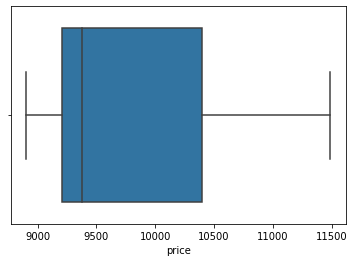

In [8]:
sns.boxplot(df.price)

### EXERCISES
#### 2.1 On a series of E-mini S&P 500 futures tick data:
#### (a) Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.


In [9]:
n_ticks = df.shape[0]
volume_ratio = (df.quantity.sum()/n_ticks).round(2)
dollar_ratio = ((df.quantity * df.price).sum()/n_ticks).round(2)
print(f'num ticks: {n_ticks:,}')
print(f'volume ratio: {volume_ratio}')
print(f'dollar ratio: {dollar_ratio}')

num ticks: 9,626,324
volume ratio: 0.54
dollar ratio: 5255.83


In [83]:
%time tbars = generate_tickbars(df, 1000)
%time vbars = generate_volumebars(df, 100)
%time dbars = generate_dollarbars(df, 10000 * 100)

CPU times: user 343 ms, sys: 119 ms, total: 462 ms
Wall time: 476 ms
CPU times: user 5.44 s, sys: 154 ms, total: 5.6 s
Wall time: 5.6 s
CPU times: user 5.57 s, sys: 154 ms, total: 5.73 s
Wall time: 5.76 s


#### (b) Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time series of that bar count. What bar type produces the most stable weekly count? Why?


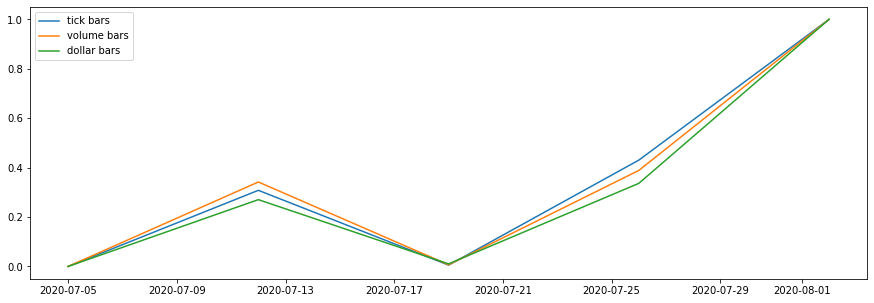

In [84]:
def count_bars(df, price_col='close'):
    return df.groupby(pd.Grouper(freq='1W'))[price_col].count()

def scale(s):
    return (s-s.min())/(s.max()-s.min())

ts = pd.DataFrame()
ts['tbars'] = scale(count_bars(tbars))
ts['vbars'] = scale(count_bars(vbars))
ts['dbars'] = scale(count_bars(dbars))

plt.figure(figsize=(15,5))
plt.plot(ts.tbars, label='tick bars')
plt.plot(ts.vbars, label='volume bars')
plt.plot(ts.dbars, label='dollar bars')
plt.legend()


In [85]:
ts.std().sort_values()

dbars   0.407217
vbars   0.407543
tbars   0.409868
dtype: float64

#### (c) Compute the serial correlation of returns for the three bar types. What bar method has the lowest serial correlation?

In [86]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

tr = returns(tbars.close)
vr = returns(vbars.close)
dr = returns(dbars.close)
  
bar_types = ['tick','volume','dollar']
bar_returns = [tr, vr, dr]

def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

autocorrs = get_test_stats(bar_types,bar_returns,pd.Series.autocorr)
display(autocorrs.sort_values('autocorr_stat'),
        autocorrs.abs().sort_values('autocorr_stat'))

,sample_size,autocorr_stat
tick,9625.000000,0.003328
dollar,48960.000000,0.027008
volume,49993.000000,0.031003


,sample_size,autocorr_stat
tick,9625.000000,0.003328
dollar,48960.000000,0.027008
volume,49993.000000,0.031003


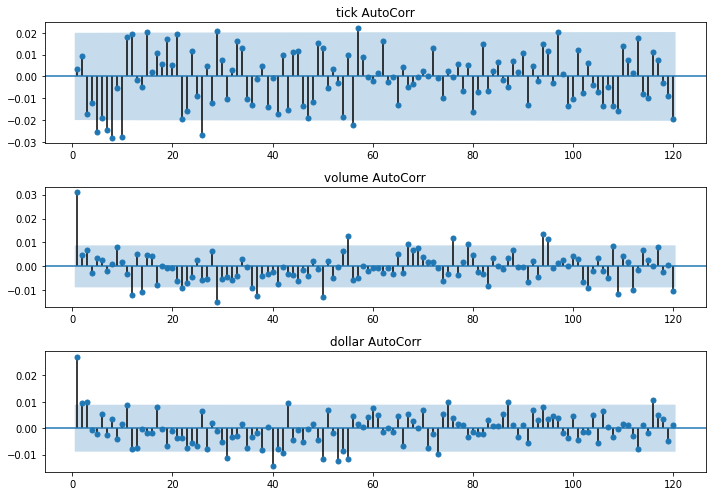

In [87]:
def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(10,7))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')
    plt.tight_layout()   
    
def plot_hist(bar_types,bar_rets):
    f,axes=plt.subplots(len(bar_types),figsize=(10,6), sharex=True)
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.distplot(bar, ax=axes[i], kde=False, label=typ)
        g.set(yscale='log')
        axes[i].legend()
    plt.tight_layout()

plot_autocorr(bar_types,bar_returns)

/Users/sebastian/GoldenEye/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


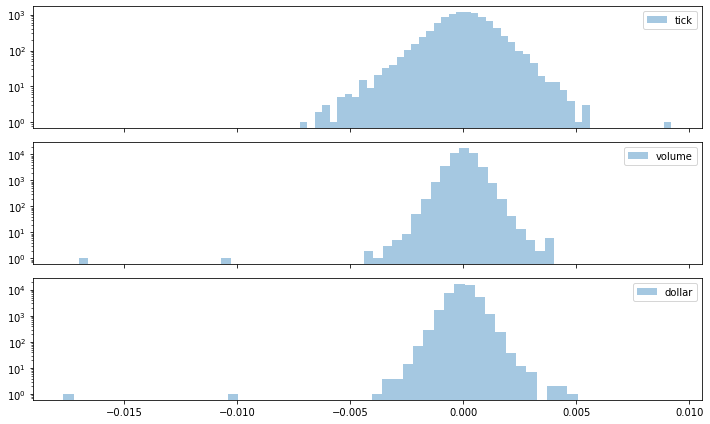

In [88]:
plot_hist(bar_types,bar_returns)

#### (d) Partition the bar series in to monthly subsets. Compute the variance of returns for every subset of every bar type. Compute the variance of those variances. What method exhibits the smallest variance of variances?

In [89]:
def partition_monthly(s):
    return s.resample('1W').var()

tr_rs = partition_monthly(tr)
vr_rs = partition_monthly(vr)
dr_rs = partition_monthly(dr)

monthly_vars = [tr_rs, vr_rs, dr_rs]

get_test_stats(bar_types,monthly_vars,np.var).sort_values('var_stat')

,sample_size,var_stat
dollar,5.000000,0.000000
volume,5.000000,0.000000
tick,5.000000,0.000000


#### (e) Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?
All the bars seem to have a very high test which signals they are not normally distributed.

In [90]:
def jb(x,test=True): 
    np.random.seed(0)
    if test: return stats.jarque_bera(x)[0]
    return stats.jarque_bera(x)[1]

get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
tick,9625.000000,1959.134073
volume,49993.000000,1813860.032795
dollar,48960.000000,2181767.072439


### 2.4 Form E-mini S&P 500 futures dollar bars:
#### (a) Compute Bollinger bands of width 5% around a rolling moving average. Count how many times prices cross the bands out (from within the bands to outside the bands).

(948, 8)


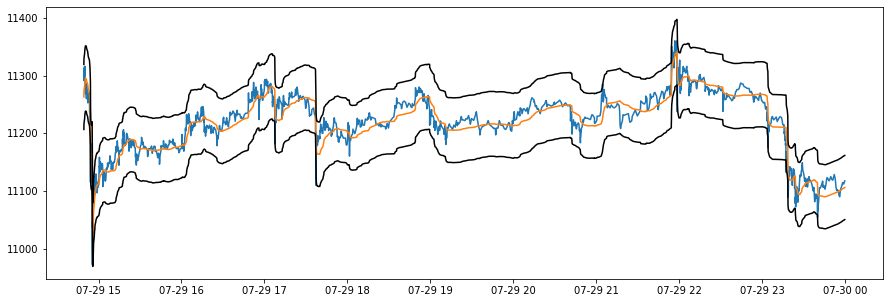

In [93]:
N = 40
pct = 0.005
show = 2000
dbars['ma'] = dbars.close.rolling(N).mean()
dbars['ut'] = dbars.ma * (1 + pct)
dbars['lt'] = dbars.ma * (1 - pct)
plt.figure(figsize=(15,5))
plt.plot(dbars.close[-show:])
plt.plot(dbars.ma[-show:])
plt.plot(dbars.ut[-show:] , color='k')
plt.plot(dbars['lt'][-show:] , color='k')

print(dbars[(dbars.close<dbars['lt']) | (dbars.close>dbars.ut)].shape)

#### (b) Now sample those bars using a CUSUM filter, where {yt} are returns and h = 0.05. How many samples do you get?

In [95]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg < -h:
            sNeg = 0; tEvents.append(i)
        elif sPos > h:
            sPos = 0; tEvents.append(i)
    return pd.DatetimeIndex(tEvents)
events = getTEvents(dbars.close, 0.05)

100%|██████████| 48959/48959 [00:02<00:00, 18759.42it/s]


In [97]:
len(events)

9

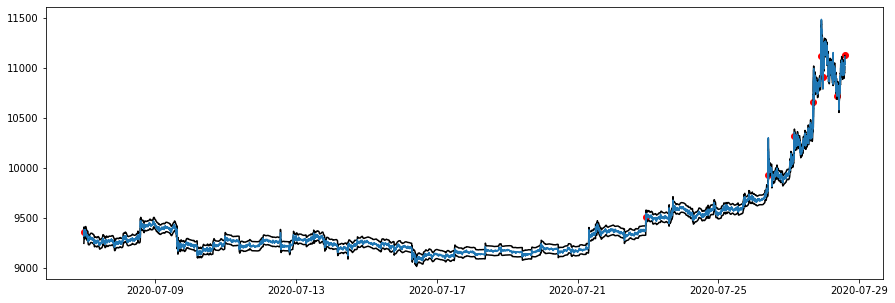

In [114]:
pltdf = dbars[(dbars.index >= '2020-07-06 23:15:00') & (dbars.index <= '2020-07-28 14:14:54')]

plt.figure(figsize=(15,5))
plt.plot(pltdf.ut , color='k')
plt.plot(pltdf['lt'] , color='k')
plt.plot(pltdf.close)
plt.scatter(events, dbars.loc[events].close, color='r')

In [120]:
pltdf.loc[e]

open     9352.000000
high     9359.630000
low      9350.000000
close    9358.410000
volume    106.932000
ma       9325.017500
ut       9371.642587
lt       9278.392412
Name: 2020-07-06 23:20:06.641000, dtype: float64

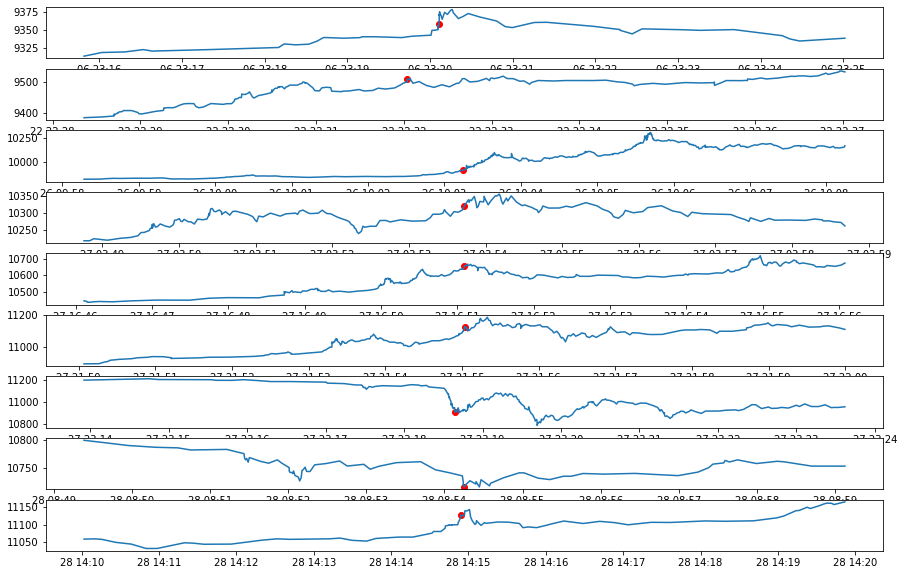

In [126]:
fig, ax = plt.subplots(len(events), 1, figsize=(15,10))
for i, e in enumerate(events):
    st = e - timedelta(minutes=5)
    ed = e + timedelta(minutes=5)
    pltdf = dbars[(dbars.index>=st)&(dbars.index<=ed)]
    ax[i].plot(pltdf.close)
    ax[i].scatter(e, pltdf.loc[e].close, color='r')



#### (c) Compute the rolling standard deviation of the two-sampled series. Which one is least heteroscedastic? What is the reason for these results?
### 2.5 Using the bars from exercise 4:
#### (a) Sample bars using the CUSUM filter, where {yt} are absolute returns and h = 0.05.


In [127]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.abs(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg < -h:
            sNeg = 0; tEvents.append(i)
        elif sPos > h:
            sPos = 0; tEvents.append(i)
    return pd.DatetimeIndex(tEvents)
events = getTEvents(dbars.close, 0.05)
len(events)

100%|██████████| 48959/48959 [00:02<00:00, 17865.57it/s]


47715

In [128]:
dbars.shape

(48961, 8)

#### (b) Compute the rolling standard deviation of the sampled bars.
#### (c) Compare this result with the results from exercise 4. What procedure delivered the least heteroscedastic sample? Why?